<a href="https://colab.research.google.com/github/ISRAEL-MP/Practica0_Comentario_codigo_-limpio/blob/main/Copia_de_Training_an_Image_Classification_Model_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Training an Image Classification Model in PyTorch***



#### The primary objective for Hub is to enable users to manage their data more easily so they can train better ML models. This tutorial shows you how to train a simple image classification model while streaming data from a Hub dataset stored in the cloud.

## Install Hub

In [ ]:
from IPython.display import clear_output
!pip3 install hub
clear_output()

## Data Preprocessing


The first step is to select a dataset for training. This tutorial uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset that has already been converted into hub format. It is a simple image classification dataset that categorizes images by clothing type (trouser, shirt, etc.)

In [ ]:
import hub
from PIL import Image
import numpy as np
import os, time
import torch
from torchvision import datasets, transforms, models

ds_train = hub.load('hub://activeloop/fashion-mnist-train')
ds_test = hub.load('hub://activeloop/fashion-mnist-test')

\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fashion-mnist-train



\

hub://activeloop/fashion-mnist-train loaded successfully.



This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fashion-mnist-test



\

hub://activeloop/fashion-mnist-test loaded successfully.



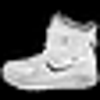

In [ ]:
Image.fromarray(ds_train.images[0].numpy()).resize((100,100))

In [ ]:
print(ds_train.labels.info.class_names[ds_train.labels[0].numpy()[0]])

Ankle boot


The next step is to define a transformation function that will process the data and convert it into a format that can be passed into a deep learning model. In this particular example, `torchvision.transforms` is used as a part of the transformation pipeline that performs operations such as normalization and image augmentation (rotation).

In [ ]:
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5], [0.5]),
])

You can now create a pytorch dataloader that connects the Hub dataset to the PyTorch model using the provided method `ds.pytorch()`. This method automatically applies the transformation function, takes care of random shuffling (if desired), and converts hub data to PyTorch tensors. The `num_workers` parameter can be used to parallelize data preprocessing, which is critical for ensuring that preprocessing does not bottleneck the overall training workflow.

The `transform` input is a dictionary where the `key` is the tensor name and the `value` is the transformation function that should be applied to that tensor. If a specific tensor's data does not need to be returned, it should be omitted from the keys. If a tensor's data does not need to be modified during preprocessing, the transformation function is set as `None`.

In [ ]:
batch_size = 32

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, transform = {'images': tform, 'labels': None}, batch_size = batch_size)
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, batch_size = batch_size)

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:121: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Model Definition

This tutorial uses a pre-trained [ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/) neural network from the torchvision.models module, converted to a single-channel network for grayscale images.

In [ ]:
# Simple model can be trained on a CPU
device = torch.device("cpu")

net = models.resnet18(pretrained=True)
# Convert model to grayscale
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
net.fc = torch.nn.Linear(net.fc.in_features, len(ds_train.labels.info.class_names))

net.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 306MB/s]


## Training the Model

Helper functions for training and testing the model are defined. Note that the dictionary that is returned by the transform function in the PyTorch dataloader is access here and is passed into the model.

In [ ]:
def train_model(loader, test_loader, model, epochs = 1):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0
        
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
        
            # Print performance statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                      (epoch + 1, i, running_loss, speed, accuracy))

                running_loss = 0.0
        
        print('Testing Model Performance')
        test_model(test_loader, model)

    print('Finished Training')
    
    
def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

The model and data are ready for training. Let's gooooooooooo 🚀!

In [ ]:
train_model(train_loader, test_loader, net, epochs = 1)

[1,     0] loss: 2.688, speed: 0.24, accuracy: 12.50 %
[1,    10] loss: 24.194, speed: 1.45, accuracy: 15.34 %
[1,    20] loss: 21.594, speed: 1.78, accuracy: 20.09 %
[1,    30] loss: 19.115, speed: 2.04, accuracy: 23.99 %
[1,    40] loss: 18.241, speed: 2.21, accuracy: 26.91 %
[1,    50] loss: 16.201, speed: 2.29, accuracy: 30.76 %
[1,    60] loss: 15.106, speed: 2.33, accuracy: 34.53 %
[1,    70] loss: 14.269, speed: 2.40, accuracy: 37.37 %
[1,    80] loss: 14.340, speed: 2.46, accuracy: 39.27 %
[1,    90] loss: 14.698, speed: 2.47, accuracy: 40.52 %
[1,   100] loss: 14.621, speed: 2.50, accuracy: 41.68 %
[1,   110] loss: 12.482, speed: 2.53, accuracy: 43.24 %
[1,   120] loss: 12.277, speed: 2.56, accuracy: 44.71 %
[1,   130] loss: 12.063, speed: 2.54, accuracy: 45.78 %
[1,   140] loss: 11.264, speed: 2.57, accuracy: 47.07 %
[1,   150] loss: 12.648, speed: 2.59, accuracy: 47.74 %
[1,   160] loss: 11.616, speed: 2.61, accuracy: 48.54 %
[1,   170] loss: 10.820, speed: 2.60, accuracy: 4

KeyboardInterrupt: ignored

Congrats! You successfully trained an image classification model while streaming data directly from the cloud! 🎉